## Introduction
On the tutorial `Simulating sequences with errors and noises`, we introduced effective noise channels and here we will go in deeper details. If you missed that tutorial, please go back there before going through this one.

Effective noise model is based on the concept of Kraus operators which are actors in the Lindblad equation. If you're not familiar with Lindblad equation and want to know deeper about, please check this ressource [here](https://ocw.mit.edu/courses/22-51-quantum-theory-of-radiation-interactions-fall-2012/resources/mit22_51f12_ch8/).

We recall the Lindblad equation:

$\frac{d \rho}{dt} = -i[\mathcal{H}, \rho] + \sum_k \left( L_k \rho L_k^\dagger - \frac{1}{2} \left\{ L_k^\dagger L_k, \rho \right\} \right)$ $\newline$

Operators $L_k$ are what we called *Collapse operators*. Basically, effective noise channel can be fully described by a set of collapse operators which are linked with each other by an equation called the *completeness relationship*:  $\sum_k N_k N_k^\dagger = \mathbb{I}$.

So varying $N_k$ gives birth to different effective noise channels. We will discuss in this tutorial two specific ones:

* The dephasing channel
* The depolarizing channel


In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation, SimConfig
from pulser_simulation.simresults import (
    CoherentResults,
    NoisyResults,
    SimulationResults,
)
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2
from pulser.devices._device_datacls import Device
from typing import Union, cast

# The dephasing channel

In this channel, each qubit interacts with its environment, and we can model this interaction with random $Z$-rotations on each qubit according to a given probability $p$, the dephasing probability.

The Corresponding collapse operators are the following: $\newline$
$M_0 = \sqrt{1-\frac{p}{2}} \mathbb{I}$ and $M_1 = \sqrt{\frac{p}{2}} \sigma_z$

### Single atom noise simulation

We prepare a single atom

In [14]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Act on this atom with a Constant Pulse, such that it oscillates towards the excited Rydberg state and back to the original state (Rabi oscillations):

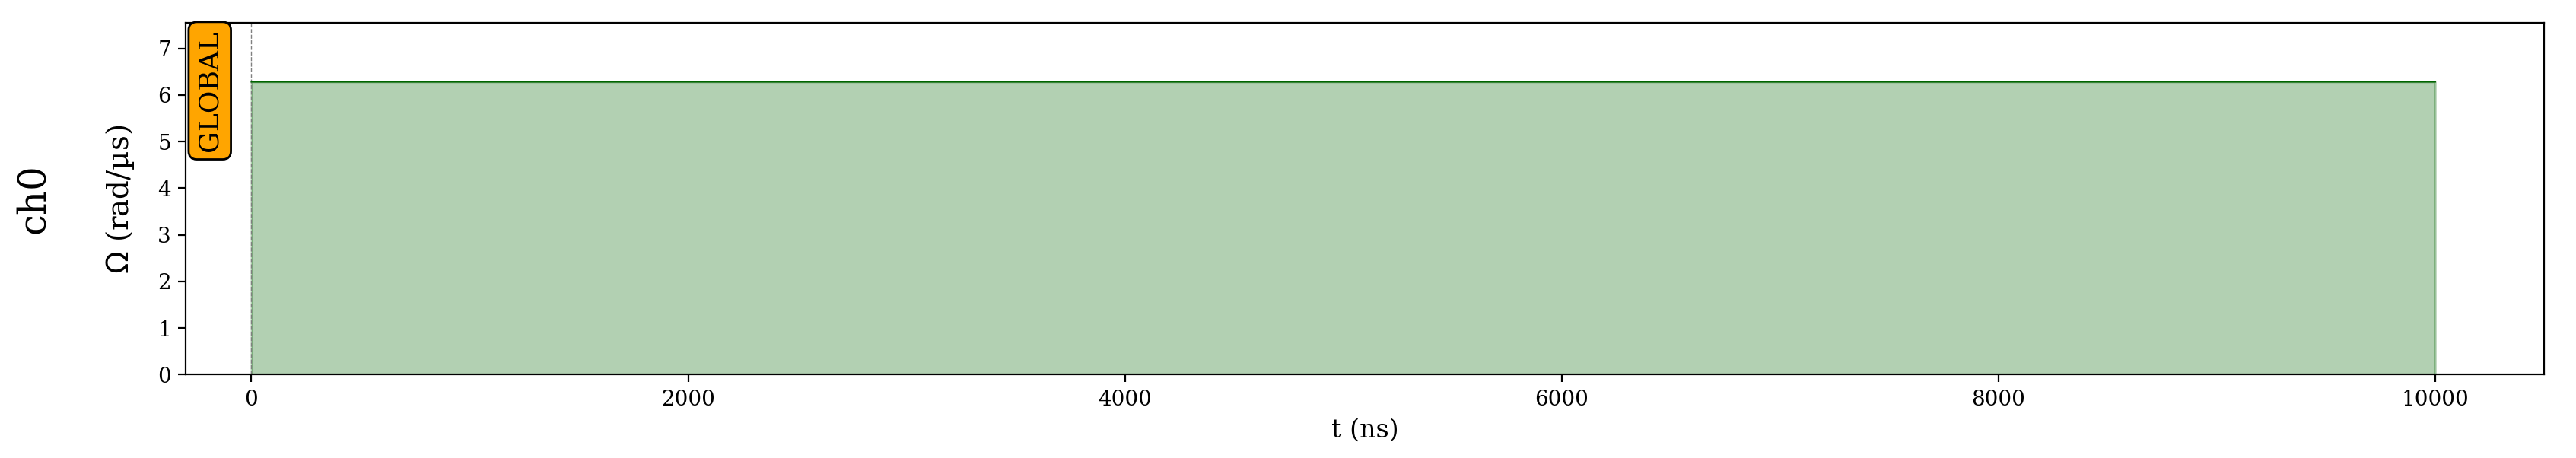

In [15]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0 * np.pi, 0.0)
seq.add(pulse, "ch0")
seq.draw()

The corresponding hamiltonian is $\mathcal{H}(t) = \frac{\hbar \Omega(t)}{2}\sigma^x$

We now run the noiseless simulation

In [16]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()

We can observe the population on the ground state using it's projector

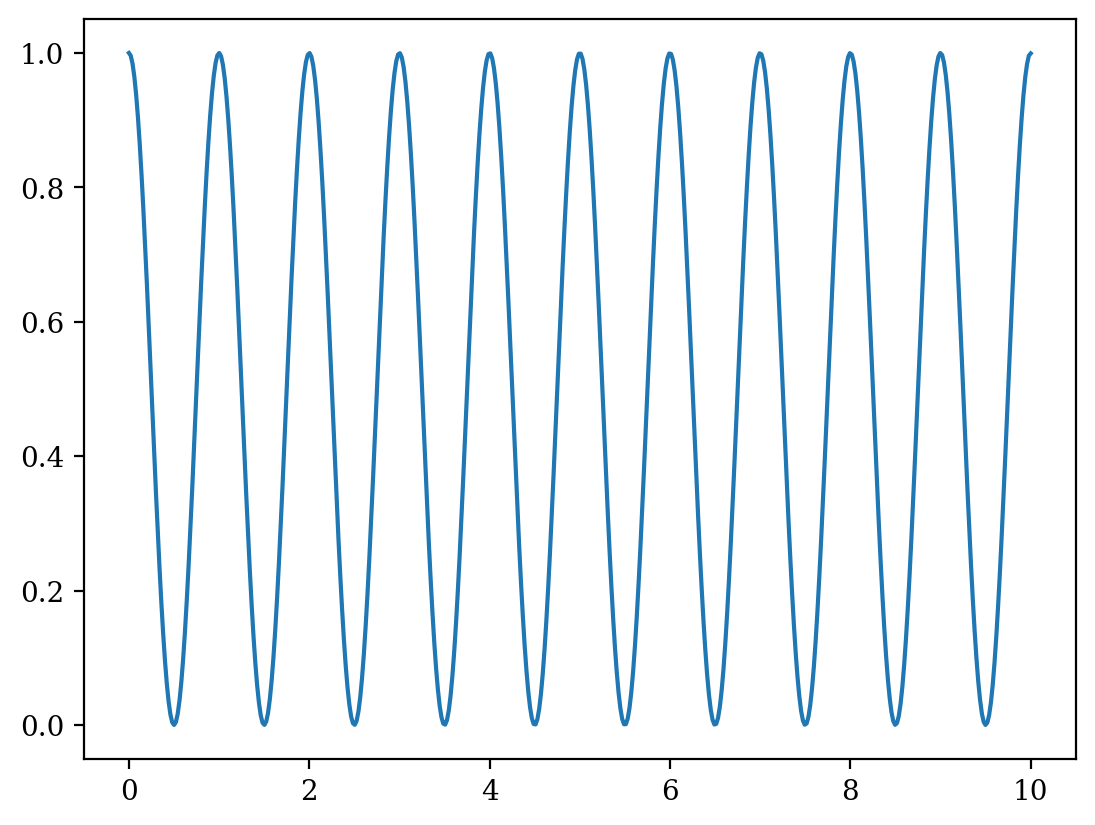

In [17]:
obs = qutip.basis(2, 1).proj()
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0])
plt.show()

The are two ways to define the dephasing channel on pulser.

The first way is by creating a `SimConfig` object, specifying you want the dephasing noise and choosing the *dephasing probability*

In [18]:
config_dephasing = SimConfig(noise="dephasing", dephasing_prob=0.1)
clean_simu.set_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           dephasing
Dephasing probability: 0.1


The second way, which is a more general way, allows not only to describe the dephasing noise, but also all effective noise channels.

In [19]:
clean_simu.reset_config()
config_dephasing = SimConfig(
    noise="eff_noise",
    eff_noise_opers=[qutip.qeye(2), qutip.sigmaz()],
    eff_noise_probs=[1 - 0.05, 0.05],
)
clean_simu.add_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           eff_noise
Effective noise distribution:       [0.95, 0.05]
Effective noise operators:       [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


Then we clean the simulation for future usage

In [20]:
clean_simu.reset_config()
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5


This is more explicit than the first method since we see the operators corresponding to the effective noise channel. In the case of the *dephasing channel*, the operators are: $\mathbb{I}$ and $\sigma_z$, which is what we see at the right of `Effective noise operators`.

Let us now simulate the entire sequence with the dephasing noise. We should see damped oscillations whenever the dephasing probability is non zero.

We define some useful functions for our simulations.

In [22]:
def get_population(rho, psi_0):
    """
    Expectation value of the input density matrix over a given direction psi_0
    """
    return psi_0.dag() * rho * psi_0


def get_population_evolution(result: SimulationResults, state):
    """
    Evolution of the expectation value of the density matrix along a state over time
    """
    population = []
    for rho_t in result.states:
        population.append(get_population(rho_t, state)[0][0])
    return population


def noisy_dynamics(clean_simu: Simulation, config: SimConfig):
    """
    Noisy simulation and metrics
    """
    simu = deepcopy(clean_simu)
    # Adding noise
    simu.add_config(config)
    result = simu.run()
    return simu, result

Then we run our simulations

In [24]:
dephasing_probabilities = np.linspace(0, 1, 5)
noisy_results = []
n_gaps = []
for dephasing_probability in dephasing_probabilities:
    print("Dephasing probability = ", dephasing_probability)

    # Configure the dephasing noise and run simulation
    config = SimConfig(noise="dephasing", dephasing_prob=dephasing_probability)
    simu, noisy_result = noisy_dynamics(clean_simu, config)
    # Gap from the no noise config
    n_gap = []
    for i in range(len(noisy_result.states)):
        n_gap.append(
            qutip.tracedist(clean_res.states[i], noisy_result.states[i])
        )

    # Storage
    noisy_results.append(noisy_result)
    n_gaps.append(n_gap)

Dephasing probability =  0.0
Dephasing probability =  0.25
Dephasing probability =  0.5
Dephasing probability =  0.75
Dephasing probability =  1.0


#### Population evolution

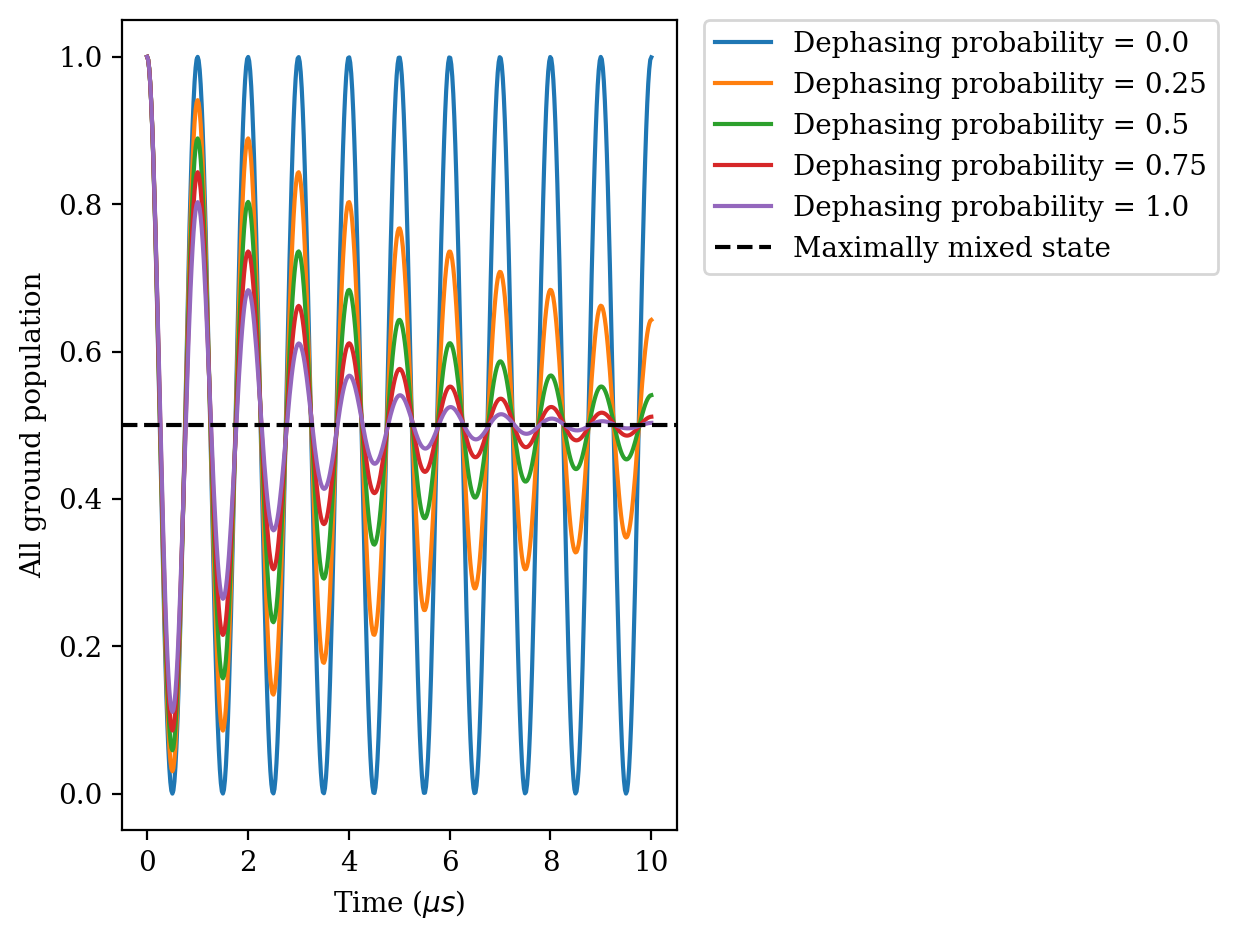

In [30]:
# Ground state population with noise
psi_0 = clean_simu.initial_state
noisy_pops = [
    get_population_evolution(noisy_result, state=psi_0)
    for noisy_result in noisy_results
]
times = noisy_results[0]._sim_times

plt.rc("font", family="serif")
plt.rc("figure", dpi=200)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All ground population")

for dephasing_probability, noisy_pop in zip(
    dephasing_probabilities, noisy_pops
):
    plt.plot(
        times,
        noisy_pop,
        label=f"Dephasing probability = {dephasing_probability}",
    )
plt.axhline(0.5, color="black", linestyle="--", label="Maximally mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

When we look at how the population at the ground state evolves with respect to the depahsing probability $p$, we notice that it converges to a stationary value, $0.5$. The speed of converge increases with $p$. 
Also the more $p$ is high, the higher the attenuation, the dephasing effects will be noticed which in this simple qubit case corresponds to a damping of the ground state population.

The final state is $\rho = \frac{1}{2} \mathbb I$, which is the maximally mixed state. This is a statistical mixture of $|0\rangle$ and $|1\rangle$: $\rho = \frac{1}{2}(|0\rangle\langle 0| + |1\rangle\langle 1|)$. Also a state of maximal uncertainty, or minimal information. We can easily check it by plotting the excited state population.

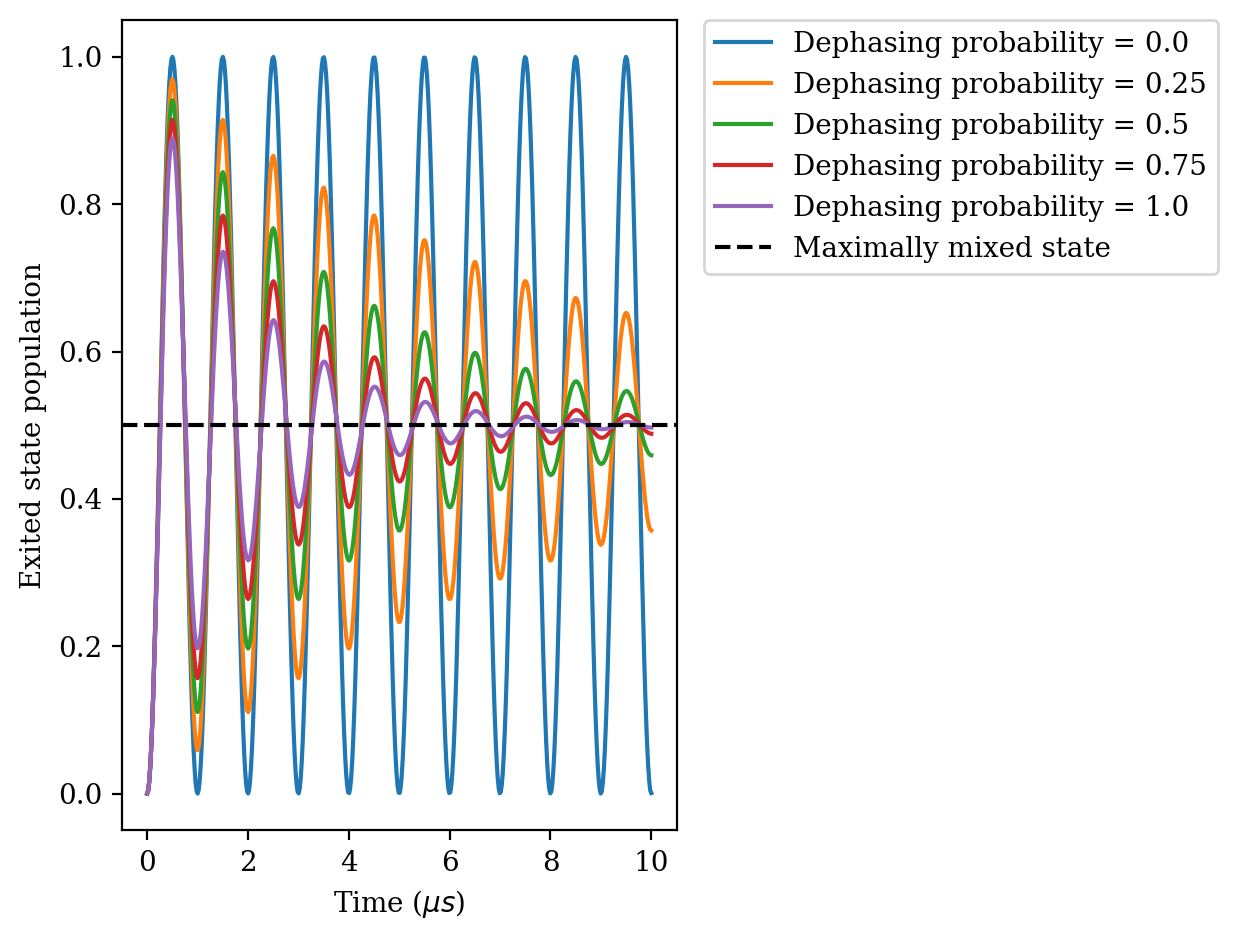

In [32]:
# Ground state population with noise
psi_0 = qutip.basis(2, 0)
noisy_pops = [
    get_population_evolution(noisy_result, state=psi_0)
    for noisy_result in noisy_results
]
times = noisy_results[0]._sim_times

plt.rc("font", family="serif")
plt.rc("figure", dpi=200)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("Exited state population")

for dephasing_probability, noisy_pop in zip(
    dephasing_probabilities, noisy_pops
):
    plt.plot(
        times,
        noisy_pop,
        label=f"Dephasing probability = {dephasing_probability}",
    )
plt.axhline(0.5, color="black", linestyle="--", label="Maximally mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

#### Trace distance

We can also look at the gap between $\rho_{noise}$ and $\rho_{clean}$ in different dephasing configuration.

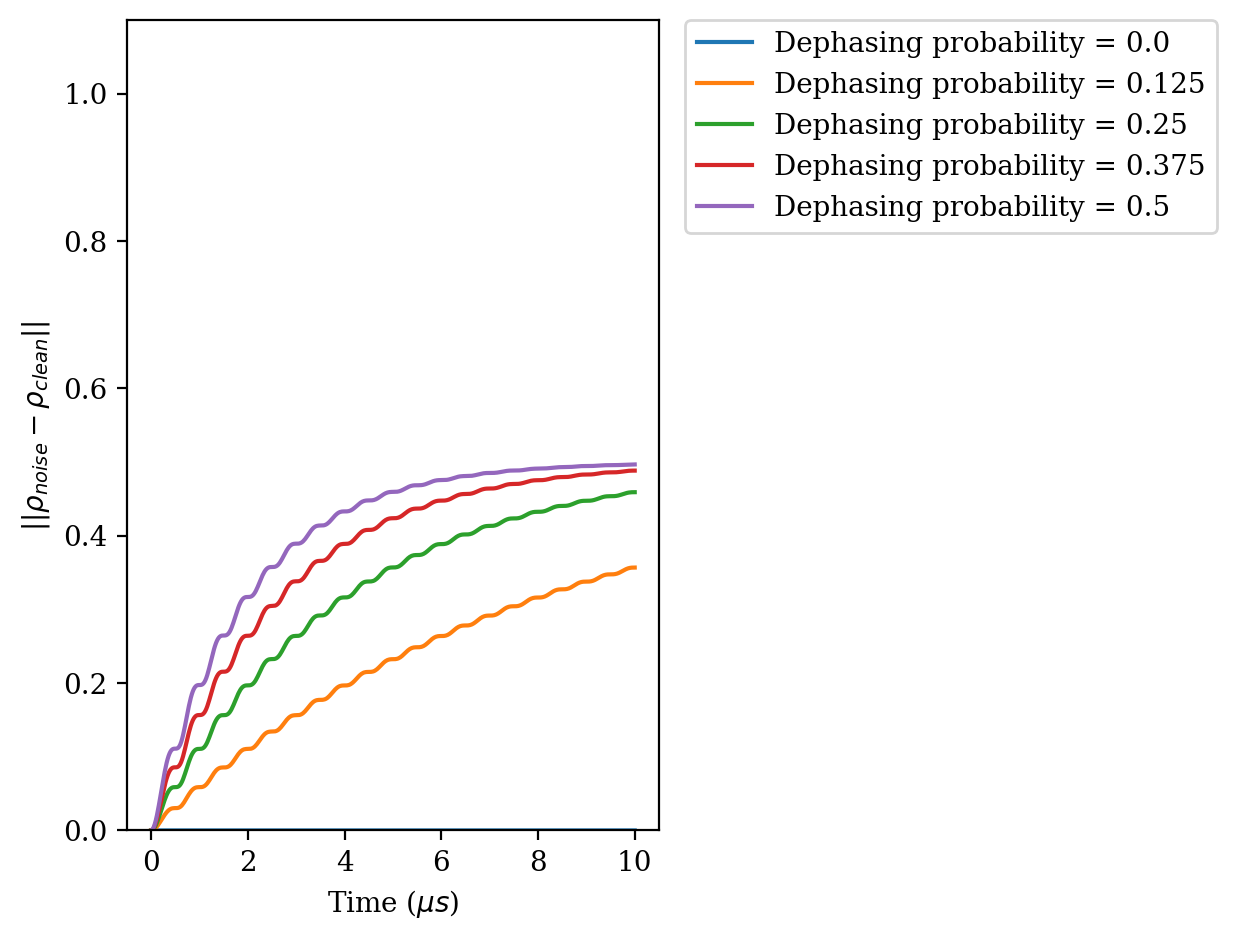

In [33]:
for dephasing_probability, dist in zip(dephasing_probabilities, n_gaps):
    plt.plot(
        times, dist, label=f"Dephasing probability = {dephasing_probability/2}"
    )
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$|| \rho_{noise} - \rho_{clean} || $")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

The distance converges to $|\rho_{max} - \rho_0|$